# 평가조건
1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.
 - 3가지 이상의 모델이 성공적으로 시도
2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
 - gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
 - 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

# 1. 모듈 임포트

In [1]:
import pandas as pd
import konlpy
import gensim
import tensorflow as tf
from konlpy.tag import Mecab
import numpy as np
from tqdm import tqdm
from collections import Counter
import os
import matplotlib.pyplot as plt

tf.random.set_seed(1234) #랜덤시드 고정

# 2. 데이터 불러오기

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

display(train_data.head())
display(test_data.head())
print('train_data 길이:{}'.format(len(train_data)))
print('test_data 길이:{}'.format(len(test_data)))

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


train_data 길이:150000
test_data 길이:50000


# 3. 데이터로더 구성

In [3]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','을','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=20000):
    # 데이터 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace = True)
    test_data.drop_duplicates(subset=['document'], inplace = True)
    
    #결측치 제거
    train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
    test_data = test_data.dropna(how = 'any')
    
    #토큰화
    X_train = []
    for sentence in tqdm(train_data['document']):
        tokenized_sentence = tokenizer.morphs(sentence) # 토큰화
        stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
        X_train.append(stopwords_removed_sentence)

    X_test = []
    for sentence in tqdm(test_data['document']):
        tokenized_sentence = tokenizer.morphs(sentence) # 토큰화
        stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
        X_test.append(stopwords_removed_sentence)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(20000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
            
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

index_to_word = {index:word for word, index in word_to_index.items()}

100%|██████████| 49157/49157 [00:04<00:00, 10782.05it/s]


- 중복되는 리뷰를 제거하고, nan가 존재하는 행을 제거해주었음
- Konlpy의 mecab을 이용하여 토큰화
- counter 함수를 이용하여 각 토큰 별 중복 카운트를 세 준 후 most_common을 이용해 10000개의 가장 빈도수가 높은 단어를 추출
- 그 후 사전을 만들어줌

# 4. 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [5]:
X_train[:3]

[[31, 73, 918, 4, 4, 38, 227, 19, 32, 747],
 [1027, 4, 10, 518, 548, 686, 5, 119, 4, 69, 1638, 51, 924, 1005, 14, 43, 390],
 [23, 204, 3]]

In [6]:
print('첫번째 리뷰 길이:{}, 원래 문장:{}'.format(len(get_decoded_sentence(X_train[0],index_to_word)),get_decoded_sentence(X_train[0],index_to_word)))
print('두번째 리뷰 길이:{}, 원래 문장:{}'.format(len(get_decoded_sentence(X_train[1],index_to_word)),get_decoded_sentence(X_train[1],index_to_word)))

첫번째 리뷰 길이:22, 원래 문장:더 빙 . . 진짜 짜증 나 네요 목소리
두번째 리뷰 길이:44, 원래 문장:. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나


## PAD, BOS, UNK, UNUSED 를 추가하는 작업

In [7]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+1) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])

<BOS>


## 데이터셋 문장 길이 확인하기

문장길이 평균 :  15.765965833755676
문장길이 최대 :  116
문장길이 표준편차 :  12.63458853764258


(array([3.5800e+03, 1.2032e+04, 2.1806e+04, 3.5640e+04, 1.9951e+04,
        1.7301e+04, 2.2188e+04, 1.1611e+04, 8.9300e+03, 9.2540e+03,
        4.1070e+03, 3.1590e+03, 3.8540e+03, 2.1380e+03, 1.9000e+03,
        2.6050e+03, 1.4640e+03, 1.3860e+03, 1.7880e+03, 1.1430e+03,
        1.1080e+03, 1.7190e+03, 1.2130e+03, 1.1470e+03, 1.0730e+03,
        1.3370e+03, 6.4300e+02, 4.6500e+02, 3.9600e+02, 1.5600e+02,
        1.0600e+02, 7.2000e+01, 3.0000e+01, 1.3000e+01, 1.3000e+01,
        1.0000e+00, 2.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  0.  ,   2.32,   4.64,   6.96,   9.28,  11.6 ,  13.92,  16.24,
         18.56,  20.88,  23.2 ,  25.52,  27.84,  30.16,  32.48,  34.8 ,
         37.12,  39.44,  41.76,  44.08,  46.4 ,  48.72,  51.04,  53.36,
         55.68,  58.  ,  60.32,  62.64,  64.96,  67.28,  69.6 ,  71.92,
         74.24,  76.56,  78.88

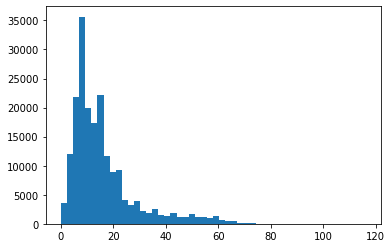

In [8]:
total_data = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

plt.hist([len(review) for review in total_data], bins=50)

- 문장은 평균 15, 최대 115의 길이를 보여줌
- 위 그래프를 봤을때 40~50 사이가 적절할 것으로 생각됨
- 아래의 함수는 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함

In [9]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [10]:
max_len = 45
below_threshold_len(max_len, total_data)

전체 샘플 중 길이가 45 이하인 샘플의 비율: 94.83308504702082


- 모든 문장의 길이를 봤을때 max_len = 45이면 전체 데이터의 약 95%를 차지함
- 따라서 모든 문장의 길이를 45으로 통일

- keras.preprocessing.sequence.pad_sequences을 활용한 패딩을 추가해줌
- 패딩은 자연어를 처리할 때 문장의 길이가 달라 행렬로 처리하기 어렵기 때문에 문장의 길이를 맞춰주어 행렬로 한번에 처리할 수 있도록 해줌
- 길이를 맞춰주기 위해 문장 뒤에 0을 붙이거나, 문장 앞에 0을 붙여준다.
- RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치기 때문에, padding 위치를 앞쪽에 넣어줌

In [11]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=max_len)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=max_len)

print(X_train.shape)
print(X_test.shape)

(146182, 45)
(49157, 45)


- 모든 데이터의 길이가 45으로 통일된것을 알 수 있음

In [12]:
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# 5. 모델 구성 및 validation set 구성

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  shuffle=True,
                                                  stratify=y_train,
                                                  random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(116945, 45)
(116945,)
(29237, 45)
(29237,)


# 6. 모델 훈련 및 훈련 시각화

In [14]:
vocab_size = 20000  # 어휘 사전의 크기입니다
word_vector_dim = 40  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 
batch_size = 512

## 6-1 RNN 모델 훈련

In [15]:
rnn_model = tf.keras.Sequential()
rnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_model.add(tf.keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용
rnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
rnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 40)          800000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               86528     
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 887,569
Trainable params: 887,569
Non-trainable params: 0
_________________________________________________________________


In [16]:
rnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 10  # 학습량

rnn_history = rnn_model.fit(x_train,
                            y_train,
                            epochs=epochs,
                            batch_size=512,
                            validation_data=(x_val, y_val),
                            verbose=1)

Epoch 1/10
229/229 [==============================] - 6s 12ms/step - loss: 0.4579 - accuracy: 0.7807 - val_loss: 0.3518 - val_accuracy: 0.8464
Epoch 2/10
229/229 [==============================] - 2s 10ms/step - loss: 0.3159 - accuracy: 0.8679 - val_loss: 0.3418 - val_accuracy: 0.8519
Epoch 3/10
229/229 [==============================] - 2s 10ms/step - loss: 0.2802 - accuracy: 0.8862 - val_loss: 0.3474 - val_accuracy: 0.8481
Epoch 4/10
229/229 [==============================] - 2s 10ms/step - loss: 0.2478 - accuracy: 0.9005 - val_loss: 0.3494 - val_accuracy: 0.8548
Epoch 5/10
229/229 [==============================] - 2s 10ms/step - loss: 0.2180 - accuracy: 0.9134 - val_loss: 0.3661 - val_accuracy: 0.8550
Epoch 6/10
229/229 [==============================] - 2s 10ms/step - loss: 0.1900 - accuracy: 0.9254 - val_loss: 0.4032 - val_accuracy: 0.8502
Epoch 7/10
229/229 [==============================] - 2s 10ms/step - loss: 0.1685 - accuracy: 0.9351 - val_loss: 0.4387 - val_accuracy: 0.8500

## Loss, Accuracy 그래프 시각화

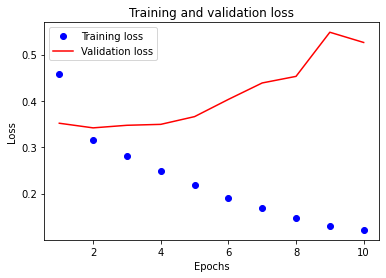

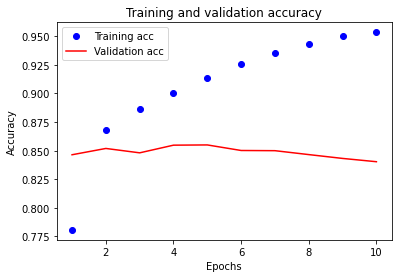

In [17]:
import matplotlib.pyplot as plt

rnn_history_dict = rnn_history.history

acc = rnn_history_dict['accuracy']
val_acc = rnn_history_dict['val_accuracy']
loss = rnn_history_dict['loss']
val_loss = rnn_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [18]:
rnn_results = rnn_model.evaluate(X_test,y_test, verbose=2)

print(rnn_results)

1537/1537 - 3s - loss: 0.5331 - accuracy: 0.8376
[0.5330734848976135, 0.8376426696777344]


## 6-2 Stack LSTM 모델 훈련

In [19]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) #vocab_size = 10000 / word_vector_dim = 40
lstm_model.add(tf.keras.layers.LSTM(units=128, return_sequences = True))
lstm_model.add(tf.keras.layers.LSTM(units=64, return_sequences = False))
lstm_model.add(tf.keras.layers.Dense(8, activation='relu'))
lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 40)          800000    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         86528     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 936,465
Trainable params: 936,465
Non-trainable params: 0
_________________________________________________________________


In [20]:
lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

lstm_model_history = lstm_model.fit(x_train,
                                    y_train,
                                    epochs=epochs,
                                    batch_size=512,
                                    validation_data=(x_val, y_val),
                                    verbose=1)

Epoch 1/10
229/229 [==============================] - 7s 18ms/step - loss: 0.4324 - accuracy: 0.7905 - val_loss: 0.3536 - val_accuracy: 0.8452
Epoch 2/10
229/229 [==============================] - 3s 15ms/step - loss: 0.3158 - accuracy: 0.8677 - val_loss: 0.3449 - val_accuracy: 0.8502
Epoch 3/10
229/229 [==============================] - 3s 15ms/step - loss: 0.2828 - accuracy: 0.8835 - val_loss: 0.3429 - val_accuracy: 0.8504
Epoch 4/10
229/229 [==============================] - 3s 15ms/step - loss: 0.2510 - accuracy: 0.8976 - val_loss: 0.3562 - val_accuracy: 0.8537
Epoch 5/10
229/229 [==============================] - 3s 15ms/step - loss: 0.2209 - accuracy: 0.9108 - val_loss: 0.3668 - val_accuracy: 0.8556
Epoch 6/10
229/229 [==============================] - 3s 15ms/step - loss: 0.1924 - accuracy: 0.9249 - val_loss: 0.3932 - val_accuracy: 0.8506
Epoch 7/10
229/229 [==============================] - 3s 15ms/step - loss: 0.1694 - accuracy: 0.9348 - val_loss: 0.4356 - val_accuracy: 0.8484

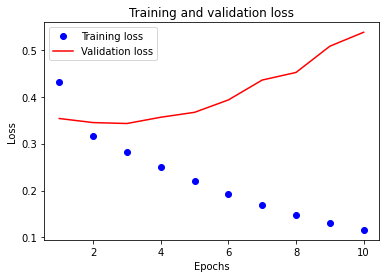

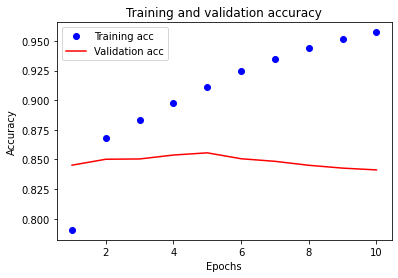

In [21]:
import matplotlib.pyplot as plt

lstm_history_dict = lstm_model_history.history

acc = lstm_history_dict['accuracy']
val_acc = lstm_history_dict['val_accuracy']
loss = lstm_history_dict['loss']
val_loss = lstm_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [22]:
lstm_results = lstm_model.evaluate(X_test,y_test, verbose=2)

print(lstm_results)

1537/1537 - 5s - loss: 0.5365 - accuracy: 0.8404
[0.5364862084388733, 0.8403889536857605]


## 6-3 BiLSTM 모델 훈련

In [23]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional

bilstm_model = tf.keras.Sequential()
bilstm_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) #vocab_size = 10000 / word_vector_dim = 40
bilstm_model.add(Bidirectional(LSTM(128)))
bilstm_model.add(tf.keras.layers.Dense(8, activation='relu'))
bilstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

bilstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 40)          800000    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               173056    
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 975,121
Trainable params: 975,121
Non-trainable params: 0
_________________________________________________________________


In [24]:
bilstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

bilstm_model_history = bilstm_model.fit(x_train,
                                        y_train,
                                        epochs=epochs,
                                        batch_size=512,
                                        validation_data=(x_val, y_val),
                                        verbose=1)

Epoch 1/10
229/229 [==============================] - 7s 21ms/step - loss: 0.4545 - accuracy: 0.7828 - val_loss: 0.3551 - val_accuracy: 0.8444
Epoch 2/10
229/229 [==============================] - 4s 18ms/step - loss: 0.3213 - accuracy: 0.8656 - val_loss: 0.3478 - val_accuracy: 0.8484
Epoch 3/10
229/229 [==============================] - 4s 18ms/step - loss: 0.2908 - accuracy: 0.8808 - val_loss: 0.3566 - val_accuracy: 0.8470
Epoch 4/10
229/229 [==============================] - 4s 18ms/step - loss: 0.2624 - accuracy: 0.8952 - val_loss: 0.3591 - val_accuracy: 0.8510
Epoch 5/10
229/229 [==============================] - 4s 18ms/step - loss: 0.2350 - accuracy: 0.9079 - val_loss: 0.3571 - val_accuracy: 0.8540
Epoch 6/10
229/229 [==============================] - 4s 18ms/step - loss: 0.2092 - accuracy: 0.9190 - val_loss: 0.3871 - val_accuracy: 0.8495
Epoch 7/10
229/229 [==============================] - 4s 18ms/step - loss: 0.1863 - accuracy: 0.9300 - val_loss: 0.4046 - val_accuracy: 0.8496

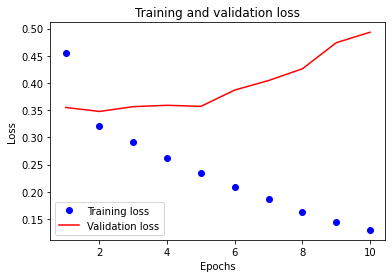

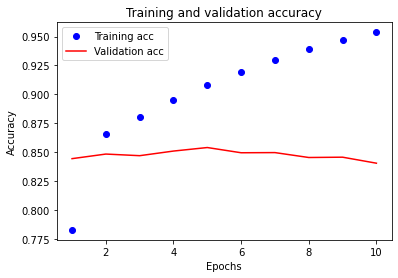

In [25]:
import matplotlib.pyplot as plt

bilstm_history_dict = bilstm_model_history.history

acc = bilstm_history_dict['accuracy']
val_acc = bilstm_history_dict['val_accuracy']
loss = bilstm_history_dict['loss']
val_loss = bilstm_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
bilstm_results = bilstm_model.evaluate(X_test,y_test, verbose=2)

print(bilstm_results)

1537/1537 - 5s - loss: 0.4999 - accuracy: 0.8384
[0.499870628118515, 0.8384360074996948]


## 전체적인 모델 평가
- 전체적으로 오버티핑이 된것을 알 수 있음
- 오버피팅을 잡기 위해 dropout이나 배치정규화를 시켜줘야 할것으로 생각됨

# 7. 학습된 Embedding 레이어 분석
- 가장 성능이 높은 stackLSTM의 Embedding 레이어를 분석

In [27]:
embedding_layer = lstm_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(20000, 40)


In [29]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = lstm_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [31]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.00248076, -0.01702612, -0.00870909,  0.02312582, -0.07763925,
        0.00592082,  0.00087741,  0.03142348, -0.06451833,  0.03656958,
       -0.04050247, -0.04621013, -0.03975071, -0.04235708,  0.05060697,
       -0.04752973, -0.03088048, -0.01357399,  0.01847456,  0.02598139,
        0.00726323,  0.04249566, -0.03238327,  0.01589494, -0.02769208,
       -0.04593669, -0.01592694,  0.00136577,  0.00336391,  0.00522923,
        0.05661075,  0.03508221,  0.00171687, -0.02524325, -0.00400579,
        0.02301108, -0.03105013, -0.00698772,  0.04695832, -0.02698336],
      dtype=float32)

In [32]:
word_vectors.similar_by_word("재미")

[('만든다', 0.8043613433837891),
 ('으세요', 0.801544725894928),
 ('하야오', 0.8009218573570251),
 ('지남', 0.8007768392562866),
 ('이다해', 0.7873069643974304),
 ('비벼', 0.7856574058532715),
 ('끝났어야', 0.7822769284248352),
 (';;;;;;', 0.7807348966598511),
 ('하리수', 0.7795752882957458),
 ('허각', 0.7770451903343201)]

- 재미와 관련된 유사한 언어를 뽑아주길 원했지만, 학습이 제대로 안된것으로 느껴짐

# 9. 한국어 Word2Vec 임베딩 활용하여 성능 개선
- 한국어로 사전학습된 word2vec을 불러와서 다시 학습시켜봄

In [38]:
# 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_path)

vector = word_vectors.wv['끝']
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [41]:
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [42]:
vocab_size = 20000    # 어휘 사전의 크기
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 word_vectors.wv 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

- 새로운 모델을 만들어서 임베딩 벡터를 교체한 후 실험

In [45]:
from tensorflow.keras.initializers import Constant

vocab_size = 20000    # 어휘 사전의 크기
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
new_lstm_model = tf.keras.Sequential()
new_lstm_model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=max_len, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
new_lstm_model.add(tf.keras.layers.LSTM(units=128, return_sequences = True, dropout=0.2))
new_lstm_model.add(tf.keras.layers.LSTM(units=128, return_sequences = True, dropout=0.2))
new_lstm_model.add(tf.keras.layers.LSTM(units=64, return_sequences = False, dropout=0.2))
new_lstm_model.add(tf.keras.layers.Dense(8, activation='relu'))
new_lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


new_lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 45, 100)           2000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 45, 128)           117248    
_________________________________________________________________
lstm_6 (LSTM)                (None, 45, 128)           131584    
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,298,769
Trainable params: 2,298,769
Non-trainable params: 0
____________________________________________

In [46]:
new_lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

new_lstm_model_history = new_lstm_model.fit(x_train,
                                        y_train,
                                        epochs=epochs,
                                        batch_size=512,
                                        validation_data=(x_val, y_val),
                                        verbose=1)

Epoch 1/10
229/229 [==============================] - 10s 30ms/step - loss: 0.5290 - accuracy: 0.7241 - val_loss: 0.4200 - val_accuracy: 0.8043
Epoch 2/10
229/229 [==============================] - 6s 27ms/step - loss: 0.4163 - accuracy: 0.8064 - val_loss: 0.3797 - val_accuracy: 0.8270
Epoch 3/10
229/229 [==============================] - 6s 27ms/step - loss: 0.3719 - accuracy: 0.8339 - val_loss: 0.3611 - val_accuracy: 0.8386
Epoch 4/10
229/229 [==============================] - 6s 27ms/step - loss: 0.3417 - accuracy: 0.8494 - val_loss: 0.3575 - val_accuracy: 0.8411
Epoch 5/10
229/229 [==============================] - 6s 27ms/step - loss: 0.3182 - accuracy: 0.8628 - val_loss: 0.3467 - val_accuracy: 0.8522
Epoch 6/10
229/229 [==============================] - 6s 27ms/step - loss: 0.3014 - accuracy: 0.8709 - val_loss: 0.3267 - val_accuracy: 0.8575
Epoch 7/10
229/229 [==============================] - 6s 27ms/step - loss: 0.2855 - accuracy: 0.8795 - val_loss: 0.3301 - val_accuracy: 0.860

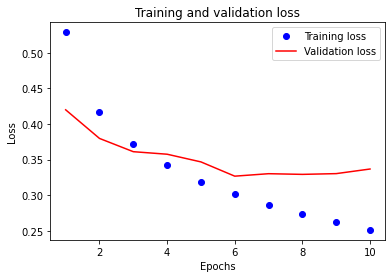

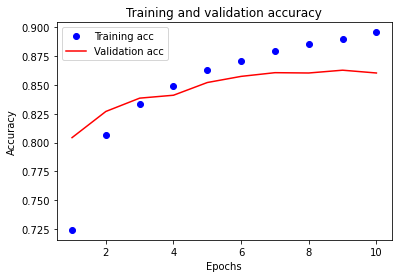

In [47]:
import matplotlib.pyplot as plt

new_lstm_history_dict = new_lstm_model_history.history

acc = new_lstm_history_dict['accuracy']
val_acc = new_lstm_history_dict['val_accuracy']
loss = new_lstm_history_dict['loss']
val_loss = new_lstm_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [48]:
new_lstm_model = new_lstm_model.evaluate(X_test,y_test, verbose=2)

print(new_lstm_model)

1537/1537 - 6s - loss: 0.3423 - accuracy: 0.8595
[0.34228208661079407, 0.8594706654548645]


## 모델 평가
- 역시 맨땅에 헤딩하는것보다 전이학습을 시킨 모델의 성능이 좋게 나왔음
- 또한 오버피팅도 어느정도 억제한것으로 생각됨

# 전체 회고
- stopwords나 전처리를 좀 더 세밀하게 했다면, baseline 모델로도 85%를 넘길 수 있었지 않았을까라는 생각이 든다.
- 허깅페이스에 있는 모델로는 감성분류를 해봤지만, 직접 사전을 구축하고 모델을 구축해서 한것은 처음이라 재미있었다.
- 딥러닝을 학습시킬때 마다 드는 생각이지만 항상 오버피팅과의 싸움이 되는 것 같다.
- 아직 레이어를 얼마나 어떻게 쌓아야하는지 감은 못잡았지만, 열심히 공부하면 잘할 수 있을 것 같다.